## Load Output of network

In [116]:
## Load .nc file
import torch
import xarray as xr

# Input Data path here:
data_path = 'output.nc'
# Load data
data = xr.open_dataset(data_path)

# Get data
pred = data['prediction']
true = data['true']
input = data['inputs']

# Convert to torch tensor
pred = torch.tensor(pred.values)
true = torch.tensor(true.values)
input = torch.tensor(input.values)

# Stats of true and pred
print("pred mean: ", pred.mean(axis=(0,2,3)))
print("pred std: ", pred.std(axis=(0,2,3)))

print("true mean: ", true.mean(axis=(0,2,3)))
print("true std: ", true.std(axis=(0,2,3)))


U = input[:, :2 ]
V = input[:, 2:]

num_samples = pred.shape[0]
# Print shape
print("prediction shape: ", pred.shape)
print("true shape: ", true.shape)
print("input shape: ", input.shape)


print("U shape: ", U.shape)
print("V shape: ", V.shape)

# Close the file
data.close()

pred mean:  tensor([2.2337e-14, 1.4137e-17])
pred std:  tensor([2.6049e-12, 9.3591e-15])
true mean:  tensor([ 2.8603e-24, -7.6178e-25])
true std:  tensor([2.7762e-12, 1.0188e-14])
prediction shape:  torch.Size([2125, 2, 64, 64])
true shape:  torch.Size([2125, 2, 64, 64])
input shape:  torch.Size([2125, 4, 64, 64])
U shape:  torch.Size([2125, 2, 64, 64])
V shape:  torch.Size([2125, 2, 64, 64])


## Show some snapshots:

mean corr:  tensor(0.9355)
max corr:  tensor(0.9639)
min corr:  tensor(0.7270)
std corr:  tensor(0.0127)
tensor([0.9315, 0.9414, 0.9443,  ..., 0.9182, 0.9303, 0.9217])
nan values index:  tensor([], size=(0, 1), dtype=torch.int64)


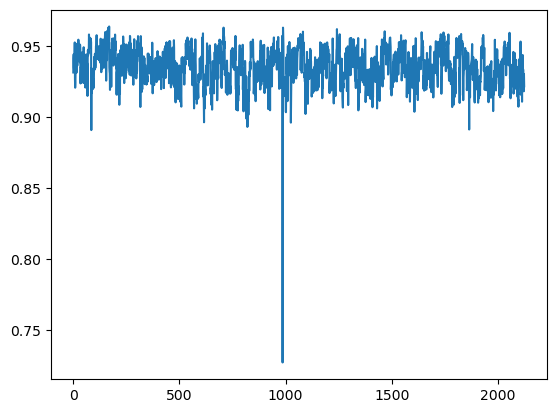

In [112]:
from utils.create_contour_plot import create_contour_plot
from utils.corr2 import corr2
import torch

index = 40
channel = 0
scale = 1e0

cc = torch.zeros(num_samples)

for i in range(num_samples):
    index = i
    channel = 0
    
    cc[i] = corr2(true[index, channel]*scale, pred[index, channel]*scale)

# Take the mean of the correlation which is not inf or nan
# cc = cc[~torch.isinf(cc)]
# cc = cc[~torch.isnan(cc)]

# Print the mean, max, min correlation
print("mean corr: ", cc.mean())
print("max corr: ", cc.max())
print("min corr: ", cc.min())
print("std corr: ", cc.std())
print(cc)
plt.plot(cc)
# Printing the nan values index
print("nan values index: ", torch.isnan(cc).nonzero())

## Raw Data

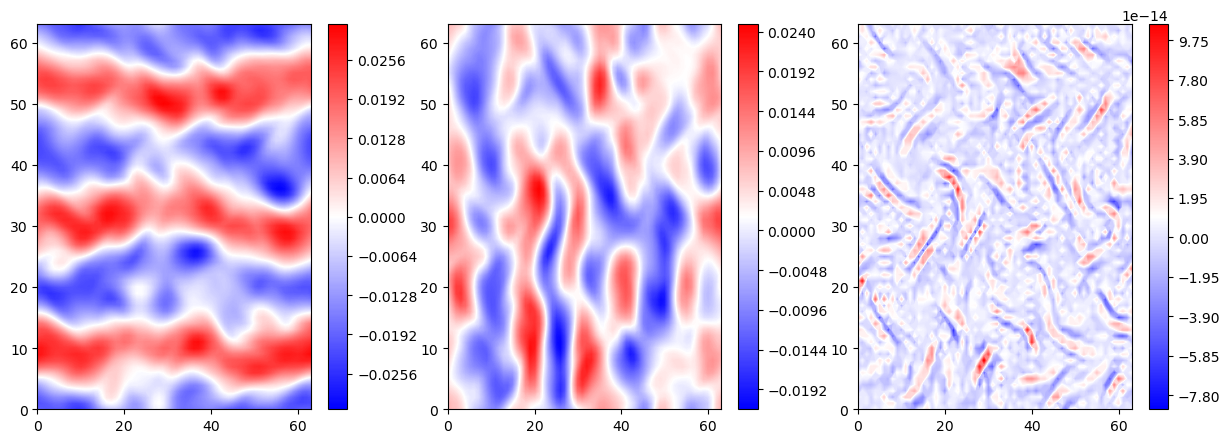

In [123]:
# Load raw data:
import matplotlib.pyplot as plt

raw = xr.open_dataset("/media/volume/sdc/data_qg/3jet/122.nc")

u = raw['u']
v = raw['v']
q = raw['q_forcing_advection']

# Convert torch tensor
u = torch.tensor(u.values)
v = torch.tensor(v.values)
q = torch.tensor(q.values)

cc_inter = torch.zeros(87)
for i in range(87):
    cc_inter[i] = corr2(q[0,0], q[i,0])

# contour of raw data 3 x 1 with colorbar
index = 60
channel = 1
fix, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].contourf(u[index,channel], cmap='bwr', levels=400)
ax[1].contourf(v[index,channel], cmap='bwr', levels=400)
ax[2].contourf(q[index,channel], cmap='bwr', levels=400)
# set colorbar for ax[2]
plt.colorbar(ax[0].contourf(u[index,channel], cmap='bwr', levels=400), ax=ax[0])
plt.colorbar(ax[1].contourf(v[index,channel], cmap='bwr', levels=400), ax=ax[1])
plt.colorbar(ax[2].contourf(q[index,channel], cmap='bwr', levels=400), ax=ax[2])

In [96]:
def spectrum_xy_averaged_2D(A, direction, spectral=False):
    Nx = A.shape[0]
    Ny = A.shape[1]

    # Generating wavenumbers
    L = 2 * torch.pi
    kx = 2 * torch.pi * torch.fft.fftfreq(Nx, d=L/Nx)
    ky = 2 * torch.pi * torch.fft.fftfreq(Ny, d=L/Ny)
    wavenumber_x, wavenumber_y = torch.meshgrid(kx, ky)

    if spectral:
        A_hat = A
    else:
        A_hat = torch.fft.fft2(A)

    # Taking abs and fftshift
    A_hat = torch.abs(A_hat)
    A_hat = torch.fft.fftshift(A_hat)

    if direction[0] == 1 and direction[1] == 0:
        A_hat_mean = A_hat.mean(axis=1)
        # A_spec = torch.flip(A_hat_mean[:Ny//2]/Ny, [0])
        A_spec = torch.flip(A_hat_mean[:Ny//2], [0])
        wavenumbers = torch.arange(0, Nx // 2)
    elif direction[0] == 0 and direction[1] == 1:
        A_hat_mean = A_hat.mean(axis=0)
        # A_spec = torch.flip(A_hat_mean[:Nx//2]/Nx, [0])
        A_spec = torch.flip(A_hat_mean[:Nx//2], [0])
        wavenumbers = torch.arange(0, Ny // 2)
    else:
        raise ValueError('Direction must be [1,0] or [0,1]')
    
    return A_spec, wavenumbers

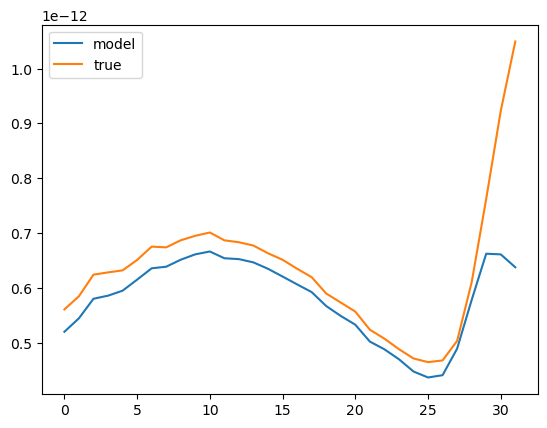

In [122]:
# Converting to torch


q_spec = torch.zeros((87, 32))
model_spec = torch.zeros((87, 32))
true_spec = torch.zeros((87, 32))
# Convert xarray to torch tensor

for i in range(87):

    q_spec[i], kq = spectrum_xy_averaged_2D(q[i,0], [0,1])
    model_spec[i], km = spectrum_xy_averaged_2D(pred[i,1], [1,0])
    true_spec[i], kt = spectrum_xy_averaged_2D(true[i,1], [1,0])



plt.plot(kq, model_spec.mean(axis=0).T, label='model')
plt.plot(kq, true_spec.mean(axis=0).T, label='true')
plt.legend()
plt.show()